<h2> Wykład 7 - rozszerzamy wtyczkę </h2>

Dzisiejszy wykład ma za zadanie przedstawić zasadniczą funkcjonalność wtyczki - możliwość odnoszenia się do narzędzi już wbudowanych w QGIS i interakcję z mapą. Dodatkowo poruszymy kwestię processingu i komunikatów.

<h3> Interakcja z mapą </h3>

Zacznijmy od dodania kilku przycisków do naszej istniejącej już wtyczki. Oprogramujemy dla nich różne przykładowe funkcjonalności.

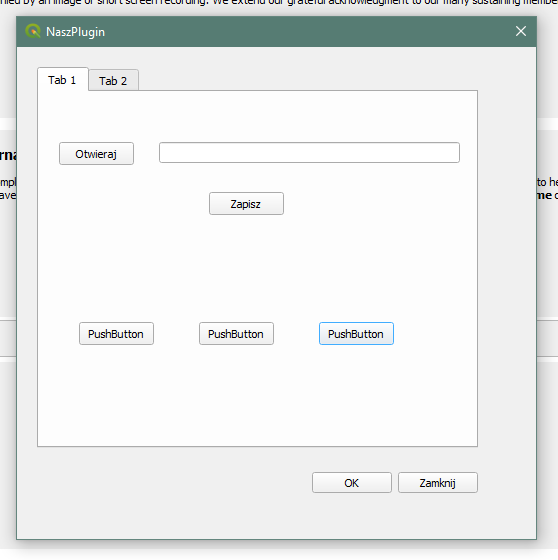

In [1]:
from IPython.display import Image, Video #taki mały imporcik do wyświetlania obrazów i wideo w tym Notebooku
Image('1.png')

Przyciski mają kolejno nazwy PushButton_3 _4 oraz _5.

Interakcje, które możemy podejmować poprzez wtyczkę odbywają się (jak zresztą w bibliotece Qt oprogramowane są wszystkie interakcje) poprzez zestaw akcji i sygnałów.

    Akcja jest uruchomieniem pewnego modułu (np. clicked.connect())
    
A sygnałem jest to co akcja zwraca.

Akcje są elementem interfejsu, spis dostępnych akcji znajduje się w dokumentacji klasy QgisInterface: https://qgis.org/pyqgis/3.2/gui/other/QgisInterface.html

Weźmy pierwszą z brzegu metodę "actionAbout" - czyli uruchomienie okna "O programie".

Najpierw w metodzie run musimy oprogramować nowy przycisk:

In [ ]:
    def run(self):
        self.window = QDialog()
        self.form = Ui_Okno()
        self.form.setupUi(self.window)
        self.form.pushButton.setText("Otwieraj")
        self.form.pushButton.clicked.connect(self.otworz)
        self.form.pushButton_2.released.connect(self.zapisz)
        self.form.checkBox.clicked.connect(self.modyfikacje)
        self.form.pushButton_3.clicked.connect(self.about) #nowy przycisk, przenosi do osobnej funkcji
        self.window.show()

Teraz oprogramujmy naszą metodą "about" tak by uruchamiała akcję przycisku actionAbout. Z pewnością potrzebne jest nam odniesienie do klasy interfejsu (to już mamy), na której wywołujemy metodę:

In [ ]:
    def about(self):
        self.iface.actionAbout().trigger() #trigger jest niezbędny, oznacza uruchomienie akcji!

Teraz po uruchomieniu wtyczki i wciśnięciu tego przycisku uruchomi nam się żądane okno:

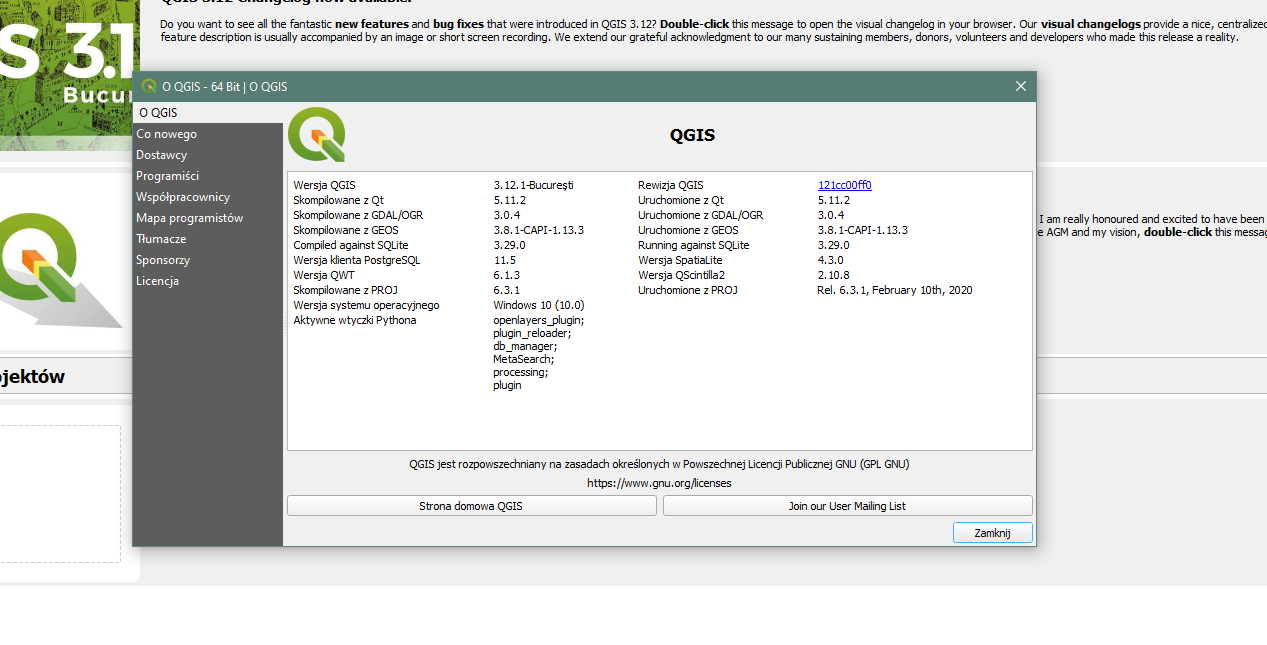

In [2]:
Image('2.png')

Spróbujmy coś bardziej skomplikowanego - akcję actionSelectRadius, która uruchamia metodę zaznaczania obiektu w zadanym promieniu. Oprogramowujemy kolejny przycisk:

In [ ]:
    def run(self):
        self.window = QDialog()
        self.form = Ui_Okno()
        self.form.setupUi(self.window)
        self.form.pushButton.setText("Otwieraj")
        self.form.pushButton.clicked.connect(self.otworz)
        self.form.pushButton_2.released.connect(self.zapisz)
        self.form.checkBox.clicked.connect(self.modyfikacje)
        self.form.pushButton_3.clicked.connect(self.about) 
        self.form.pushButton_4.clicked.connect(self.select) #nowy przycisk
        self.window.show()

Teraz piszemy funkcję:

In [ ]:
    def select(self):
        self.iface.actionSelectRadius().trigger()

Uwaga: by działało musi być załadowana jakaś warstwa.

Funkcja działa, ale dość niewygodne jest okno wtyczki, które zasłania nam widok. Dlatego oprogramujmy je tak by znikało, kiedy uruchomimy operację, a po kliknięciu na obiekt znów się pojawiało. I wbrew pozorom, niestety, wymaga to większej liczby linijek kodu:

In [ ]:
    def select(self):
        self.iface.actionSelectRadius().trigger()
        self.window.hide() #chowa okno
        layer = self.iface.activeLayer() #aktywna warstwa w tle
        layer.selectionChanged.connect(self.end_select)

W linijce 5 musimy sprawdzić czy obiektu już zostały zaznaczone. Wykorzystujemy do tego sygnał "selectionChanged" na aktywnej warstwie. Czyli kiedy zaznaczenie zostało zmienione, wtedy należy znów pokazać okno. Sygnały mogą jednak łączyć się wyłącznie z innymi funkcjami, więc pokazanie okna musimy uruchomić w innej funkcji.

In [ ]:
    def end_select(self):
        self.window.show()

Jednakże, w ten sposób narzędzie wyboru będzie nadal włączone w tle. Należy jeszcze przed pokazaniem okna je wyłączyć:

In [ ]:
    def end_select(self):
        layer = self.iface.activeLayer() #aktywna warstwa w tle
        layer.selectionChanged.disconnect(self.end_select) #"rozłączamy" funkcję od sygnału
        self.window.show()

Co możemy zrobić z wybranym obiektem? Na przykład odczytać jego koordynaty:

In [ ]:
    def end_select(self):
        layer = self.iface.activeLayer() #aktywna warstwa w tle
        feature = layer.selectedFeatures()[0] #pobieramy zaznaczony obiekt
        geom = feature.geometry() #jego geometrię
        x = geom.asPoint().x() #i jego współrzędne
        y = geom.asPoint().y()
        #tu można coś z nimi zrobić
        layer.selectionChanged.disconnect(self.end_select) #"rozłączamy" funkcję od sygnału
        self.window.show()

Jeśli chcemy te koordynaty zachować na później możemy przypisać te wartości do self lub zastosować trik polegający na ich zapisaniu w widżecie. Na przykład w pasku tekstu:

In [ ]:
    def end_select(self):
        layer = self.iface.activeLayer() #aktywna warstwa w tle
        feature = layer.selectedFeatures()[0] #pobieramy zaznaczony obiekt
        geom = feature.geometry() #jego geometrię
        x = geom.asPoint().x() #i jego współrzędne
        y = geom.asPoint().y()
        self.form.lineEdit.setText("{},{}".format(str(x),str(y))) #i zapisujemy do lineEdit
        layer.selectionChanged.disconnect(self.end_select) #"rozłączamy" funkcję od sygnału
        self.window.show()

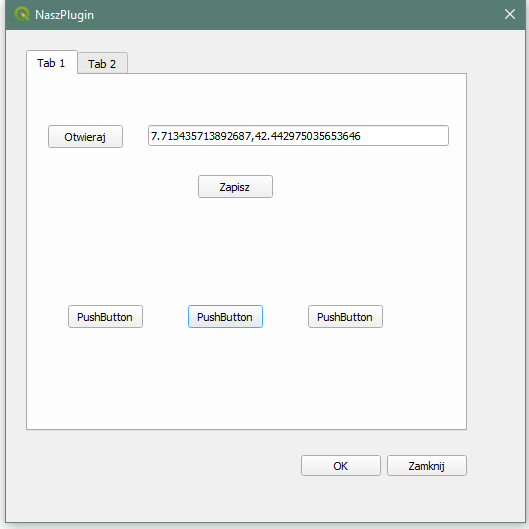

In [3]:
Image('3.png')

<h3> Komunikaty </h3>

Czasem przydatne jest wyświetlanie komunikatów, które mogą być wyświetlane na górnym pasku lub w osobnym oknie. Zobaczmy, jak takie komunikaty oprogramować. Niech kliknięcie naszego trzeciego nowego przycisku uruchamia komunikat na pasku:

In [ ]:
    def run(self):
        self.window = QDialog()
        self.form = Ui_Okno()
        self.form.setupUi(self.window)
        self.form.pushButton.setText("Otwieraj")
        self.form.pushButton.clicked.connect(self.otworz)
        self.form.pushButton_2.released.connect(self.zapisz)
        self.form.checkBox.clicked.connect(self.modyfikacje)
        self.form.pushButton_3.clicked.connect(self.about)
        self.form.pushButton_4.clicked.connect(self.select)
        self.form.pushButton_5.clicked.connect(self.inform) #nowa funkcja
        self.window.show()

Oprogramowanie samego paska to jedna linijka. Atrybuty w kolejności to:

    1 - tytuł błędu
    2 - tekst błędu
    3 - typ błędu (zmienia kolor paska i symbol)
    4 - czas wyświetlania

In [ ]:
    def inform(self):
        self.iface.messageBar().pushMessage("COTO", "Pasek z błędem", level=Qgis.Critical, duration=3)

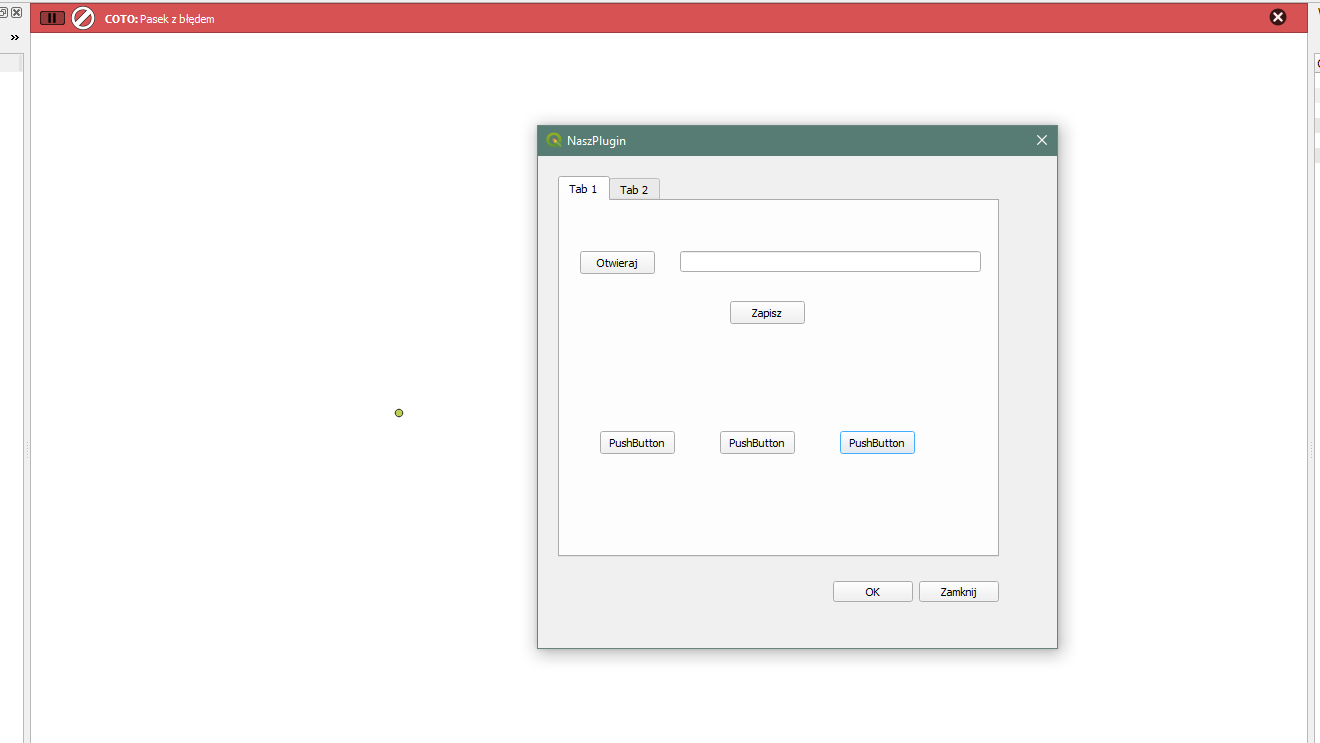

In [4]:
Image('4.png')

Oczywiście w tekst błędu możemy wstawiać informacje dotyczące tego co obecnie dzieje się we wtyczce. Do tego należy użyć formatowania tekstu.
Inne dostępne paski to:


    Qgis.Info

    Qgis.Warning

    Qgis.Critical

    Qgis.Success


O ile pasek jest elementem QGISa to już okno z informacją jest elementem biblioteki Qt. Dlatego też odwołujemy się do niej. Aby pokazać okno wystarczy wpisać:

In [ ]:
    def inform(self):
        QMessageBox.information(None, "Tytuł", "Tekst")

Pierwszy argument odpowiada za typ okna - wywoływane są liczbami od 0 do 4 włącznie.

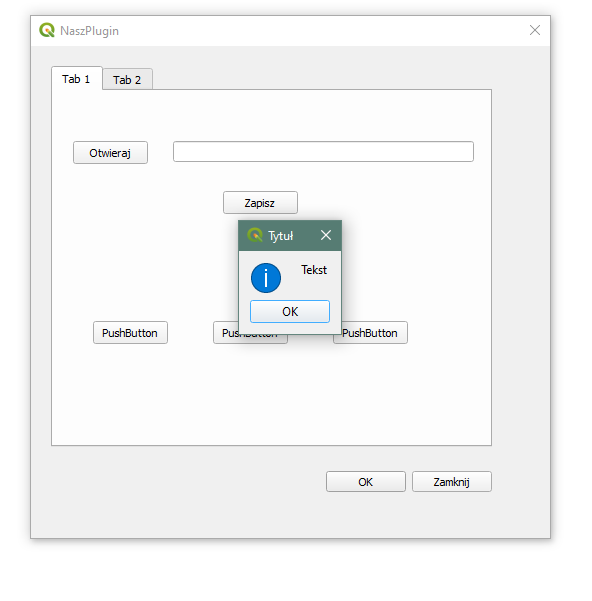

In [5]:
Image('5.png')

<h3> Narzędzia processingu </h3>

Narzędzia processingu są bardzo przydatnymi funkcjami do przetwarzania danych wektorowych i rastrowych. Mogą być używane zarówno w formie skryptów jak i części własnych wtyczek. Narzędzia processingu dostępne w QGIS są na górnym pasu w menu "Processing -> Panel algorytmów"

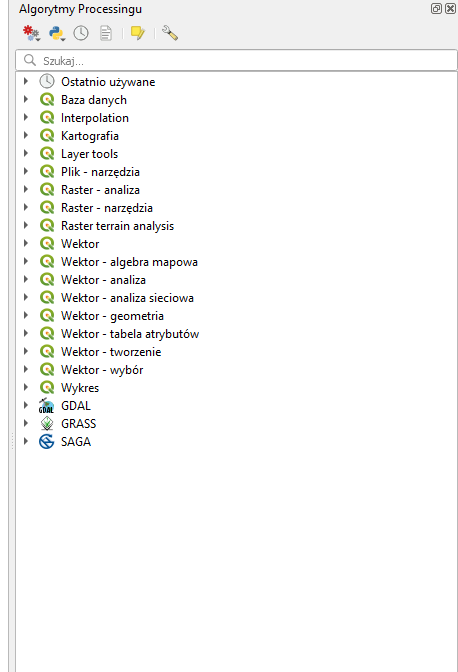

In [6]:
Image('6.png')

Narzędzia processingu to takie metody jak operatory przecięcia, buforowania itp, ale również bardziej zaawansowane metody jak analizy sieciowe czy operacje na rastrach (stoki, ekspozycja, nachylenia). Aby korzystać z narzędzi processingu należy najpierw zaimportować moduł processingu:

In [ ]:
import processing

Nadpiszę funkcjonalność naszej funkcji z ostatniego przycisku. Wykorzystanie metody processingu ogranicza się do zapytania:

In [ ]:
processing.run(#nazwa algorytmu, #argumenty)

Do tych algorytmów nie ma jednak dokumentacji. Zamiast tego możemy w konsoli sprawdzić jakie algorytmy są dostępne:

In [ ]:
for alg in QgsApplication.processingRegistry().algorithms():
        print(alg.id(), "->", alg.displayName())

Wyświetli nam to listę algorytmów z opisem. Gdy znamy nazwę algorytmu, możemy sprawdzić jakie przyjmuje parametry:

In [ ]:
processing.algorithmHelp('native:buffer')

Odpowiedź:

Bufor (native:buffer)

Algorytm oblicza obszar bufora dla wszystkich obiektów warstwy wejściowej wykorzystując stałą lub zmienna szerokość bufora.

Parametr liczby segmentów określa stopień zaokrąglenia załamań bufora.

Parametr stylu zakończenia określa jak będą traktowane zakończenia linii w buforze.

Parametr stylu połączenia określa w jaki sposób łączone będą linie podczas tworzenia bufora wokół załamań linii.

Parametr limitu fazy (uciosu) może być zastosowany tylko dla ostrych połączeń i określa maksymalną odległość od buforowanego załamania podczas tworzenia ostrych połączeń.


----------------
Input parameters
----------------

INPUT: Warstwa źródłowa

	Parameter type:	QgsProcessingParameterFeatureSource

	Accepted data types:
		- str: ID warstwy
		- str: nazwa warstwy
		- str: źródło warstwy
		- QgsProcessingFeatureSourceDefinition
		- QgsProperty
		- QgsVectorLayer

DISTANCE: Odległość

	Parameter type:	QgsProcessingParameterDistance

	Accepted data types:
		- int
		- float
		- QgsProperty

SEGMENTS: Segmenty

	Parameter type:	QgsProcessingParameterNumber

	Accepted data types:
		- int
		- float
		- QgsProperty

END_CAP_STYLE: Styl zakończenia

	Parameter type:	QgsProcessingParameterEnum

	Available values:
		- 0: zaokrąglony
		- 1: płaski
		- 2: kwadratowy

	Accepted data types:
		- int
		- str: liczba rzeczywista zapisana jako string, np. '1'
		- QgsProperty

JOIN_STYLE: Styl połączenia

	Parameter type:	QgsProcessingParameterEnum

	Available values:
		- 0: zaokrąglony
		- 1: ostry
		- 2: ścięty

	Accepted data types:
		- int
		- str: liczba rzeczywista zapisana jako string, np. '1'
		- QgsProperty

MITER_LIMIT: Limit fazy (uciosu)

	Parameter type:	QgsProcessingParameterNumber

	Accepted data types:
		- int
		- float
		- QgsProperty

DISSOLVE: Agreguj wyniki

	Parameter type:	QgsProcessingParameterBoolean

	Accepted data types:
		- bool
		- int
		- str
		- QgsProperty

OUTPUT: Bufor

	Parameter type:	QgsProcessingParameterFeatureSink

	Accepted data types:
		- str: docelowy plik wektorowy, np. 'd:/test.shp'
		- str: 'memory:' w celu zachowania wyników jako warstwa tymczasowa
		- str: ID dostawcy danych wektorowych i adresu URI przeznaczenia, np. 'postgres:…', aby zachować wynik w tabeli PostGIS
		- QgsProcessingOutputLayerDefinition
		- QgsProperty

----------------
Outputs
----------------

OUTPUT:  <QgsProcessingOutputVectorLayer>
	Bufor

Oznacza to, że zapytanie dla tej funkcji processingu będzie wyglądać tak:

In [ ]:
processing.run("native:buffer", {'INPUT': '/data/lines.shp',
              'DISTANCE': 100.0,
              'SEGMENTS': 10,
              'DISSOLVE': True,
              'END_CAP_STYLE': 0,
              'JOIN_STYLE': 0,
              'MITER_LIMIT': 10,
              'OUTPUT': '/data/buffers.shp'})

Argumenty podajemy zatem w formie słownika. Przy opisie funkcji podane są postacie argumentów jakie są akceptowalne w funkcji.